In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

/home/zim003/miniforge3/envs/swali/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
#---
def load_alignment_matrix(id1, id2, comparison_id, method='tm'):
    try:
        with open(f"../datasets/analogs_ali/{comparison_id}/{comparison_id}.{method}.ali") as f:
            lines = [line.strip() for line in f if line.strip()]
            seq1, seq2 = lines
    except FileNotFoundError:
        return None

    resid1_indices = [i for i, res in enumerate(seq1) if res != '-']
    resid2_indices = [j for j, res in enumerate(seq2) if res != '-']

    resid1_map = {i: idx for idx, i in enumerate(resid1_indices)}
    resid2_map = {j: idx for idx, j in enumerate(resid2_indices)}

    matrix = np.zeros((len(resid1_indices), len(resid2_indices)), dtype=int)

    for aln_pos, (a, b) in enumerate(zip(seq1, seq2)):
        if a != '-' and b != '-':
            if a.isupper() and b.isupper():
                i = resid1_map.get(aln_pos)
                j = resid2_map.get(aln_pos)
                if i is not None and j is not None:
                    matrix[i, j] = 1
    return matrix

#---

def compute_threshold_alignment_recall(sim_matrix, align_matrix, threshold=0.15):
    L1, L2 = sim_matrix.shape

    tp = 0
    fp = 0
    fn = 0

    for i in range(L1):
        predicted_matches = []
        true_matches = []

        for j in range(L2):
            if sim_matrix[i, j] >= threshold:
                predicted_matches.append(j)
            if i < align_matrix.shape[0] and j < align_matrix.shape[1]:
                if align_matrix[i, j] == 1:
                    true_matches.append(j)

        # True positives: overlap of predicted and true
        tp += len(set(predicted_matches) & set(true_matches))
        # False positives: predicted but not true
        fp += len(set(predicted_matches) - set(true_matches))
        # False negatives: true but not predicted
        fn += len(set(true_matches) - set(predicted_matches))

    # Metrics
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    return recall, precision, f1

#---

def evaluate_threshold_sweep(df, embeddings_by_method, thresholds, window_size=1):
    results = []

    grouped = df.groupby('PAIR')
    for comparison_id, group in grouped:
        proteins = group['EMBEDDINGid'].unique()
        for id1, id2 in combinations(proteins, 2):
            for method, protein_embeddings in embeddings_by_method.items():
                try:
                    emb1 = protein_embeddings[id1]
                    emb2 = protein_embeddings[id2]
                    sim_matrix = cosine_similarity(emb1, emb2)
                except ValueError as e:
                    print(f"Skipping {id1}-{id2} for {method} due to error: {e}")
                    continue

                align_matrix = load_alignment_matrix(id1, id2, comparison_id)
                if align_matrix is None:
                    continue

                for threshold in thresholds:
                    recall, precision, f1score = compute_threshold_alignment_recall(sim_matrix, align_matrix, threshold=threshold)
                    results.append({
                        'comparison_id': comparison_id,
                        'method': method,
                        'threshold': threshold,
                        'Recall': recall,
                        'Precision': precision,
                        'F1-Score': f1score
                    })

    return pd.DataFrame(results)

#---

In [3]:
embeddings_by_method = {
    'ProtT5': pickle.load(open("../embeddings/prott5_aligned_embs.pkl", "rb")),
    'ESM-2(3B)': pickle.load(open("../embeddings/esm2_3B_aligned_embs.pkl", "rb")),
    'ESM-2(15B)': pickle.load(open("../embeddings/esm2_15B_aligned_embs.pkl", "rb")),
    'CARP': pickle.load(open("../embeddings/carp_aligned_embs.pkl", "rb")),
    'ProstT5': pickle.load(open("../embeddings/prostt5_aligned_embs.pkl", "rb"))
}

df = pd.read_csv("../datasets/malisam_sequences_aligned.csv")
df["EMBEDDINGid"] = df["SCOPid"].astype(str) + '_' + df.index.astype(str)

thresholds = [round(x, 2) for x in np.arange(-1, 1.05, 0.05)]

results_df = evaluate_threshold_sweep(
    df,
    embeddings_by_method,
    thresholds=thresholds,
    window_size=1
)

In [4]:
results_df

,comparison_id,method,threshold,Recall,Precision,F1-Score
0,d1a05a_d1dgsa3,ProtT5,-1.00,1.0,0.009115,0.018065
1,d1a05a_d1dgsa3,ProtT5,-0.95,1.0,0.009115,0.018065
2,d1a05a_d1dgsa3,ProtT5,-0.90,1.0,0.009115,0.018065
3,d1a05a_d1dgsa3,ProtT5,-0.85,1.0,0.009115,0.018065
4,d1a05a_d1dgsa3,ProtT5,-0.80,1.0,0.009115,0.018065
...,...,...,...,...,...,...
26645,d6mhta_d1vm0b_,ProstT5,0.80,0.0,0.000000,0.000000
26646,d6mhta_d1vm0b_,ProstT5,0.85,0.0,0.000000,0.000000
26647,d6mhta_d1vm0b_,ProstT5,0.90,0.0,0.000000,0.000000
26648,d6mhta_d1vm0b_,ProstT5,0.95,0.0,0.000000,0.000000


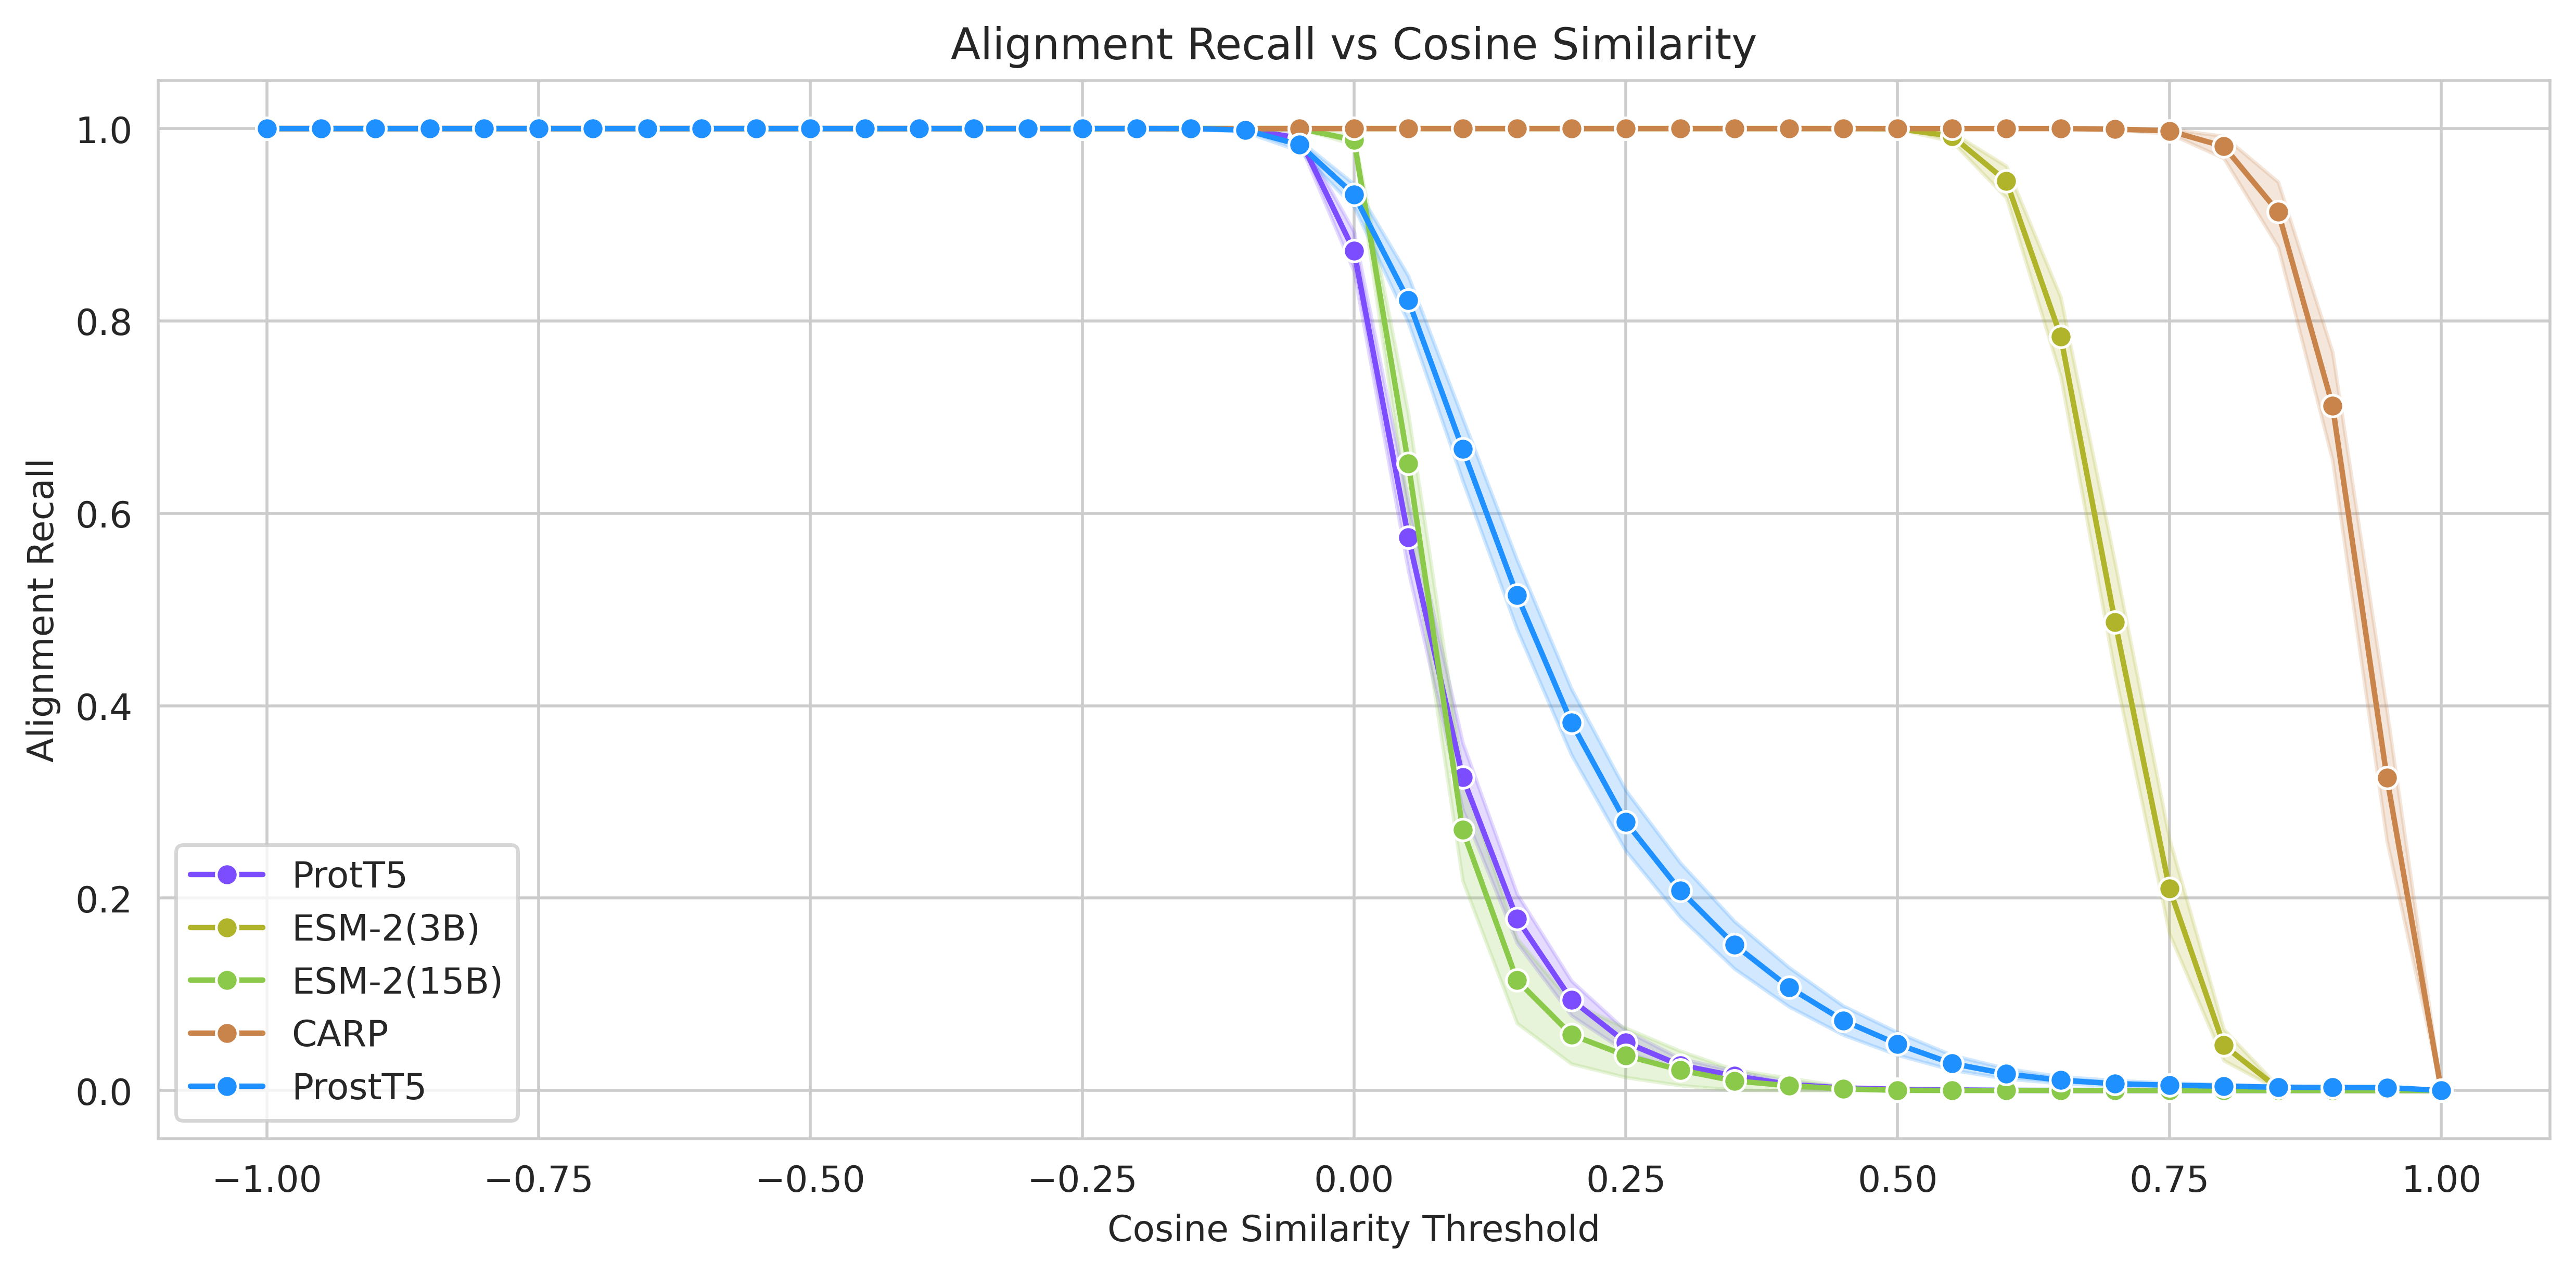

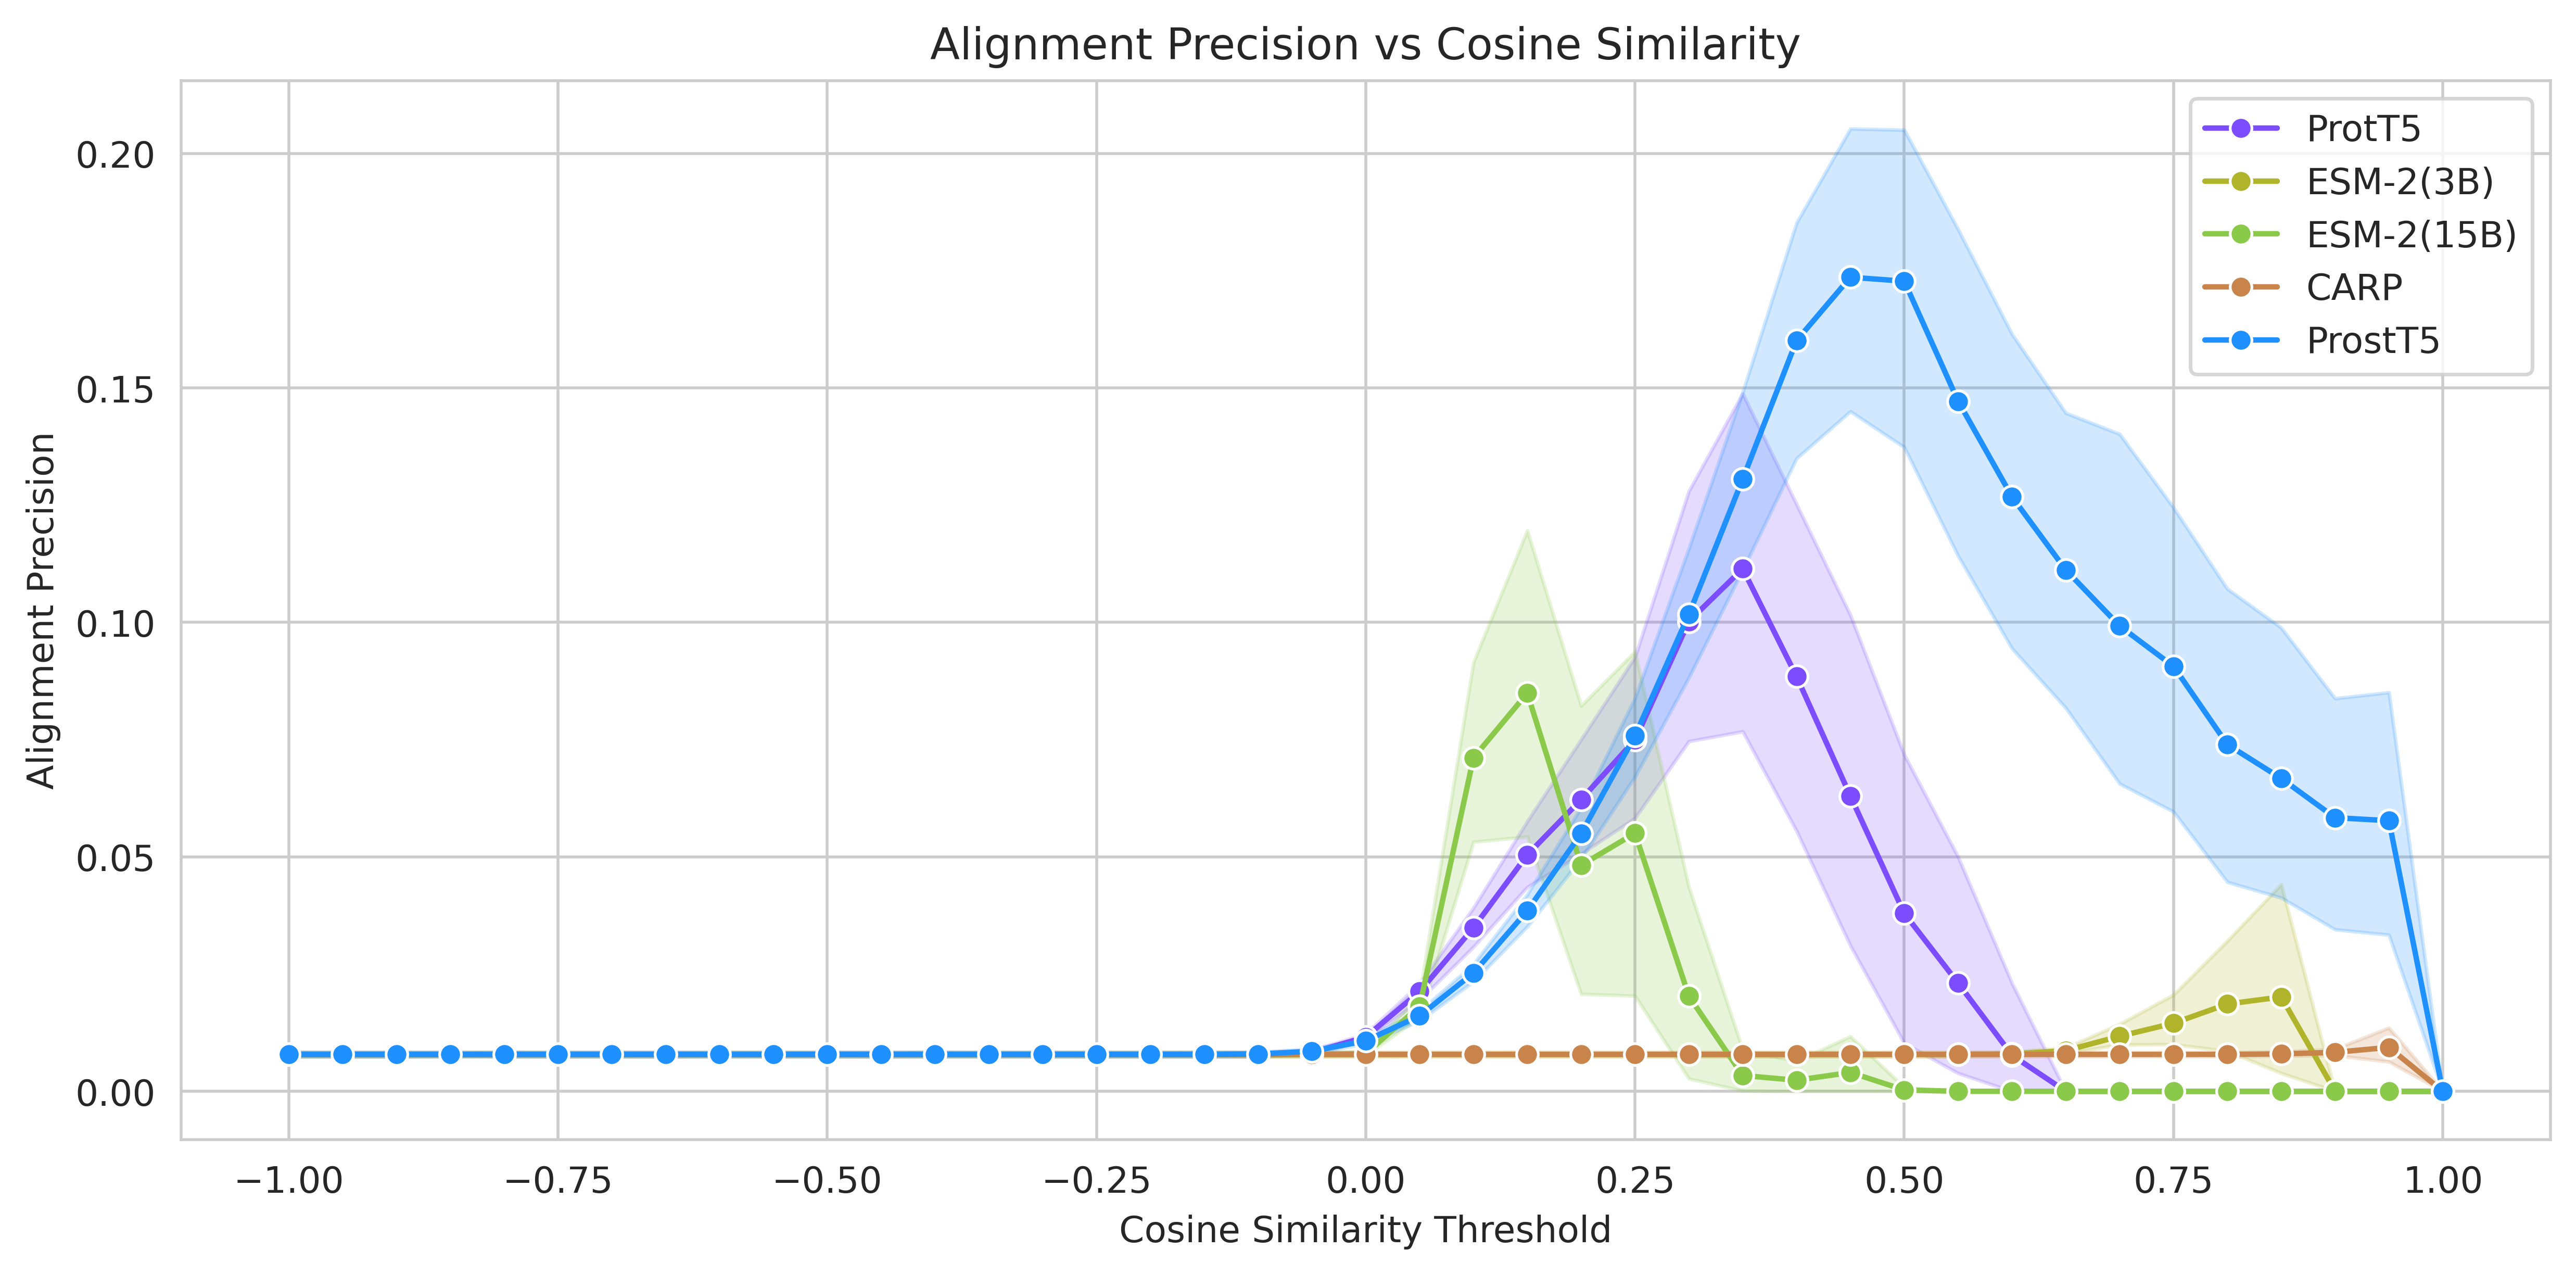

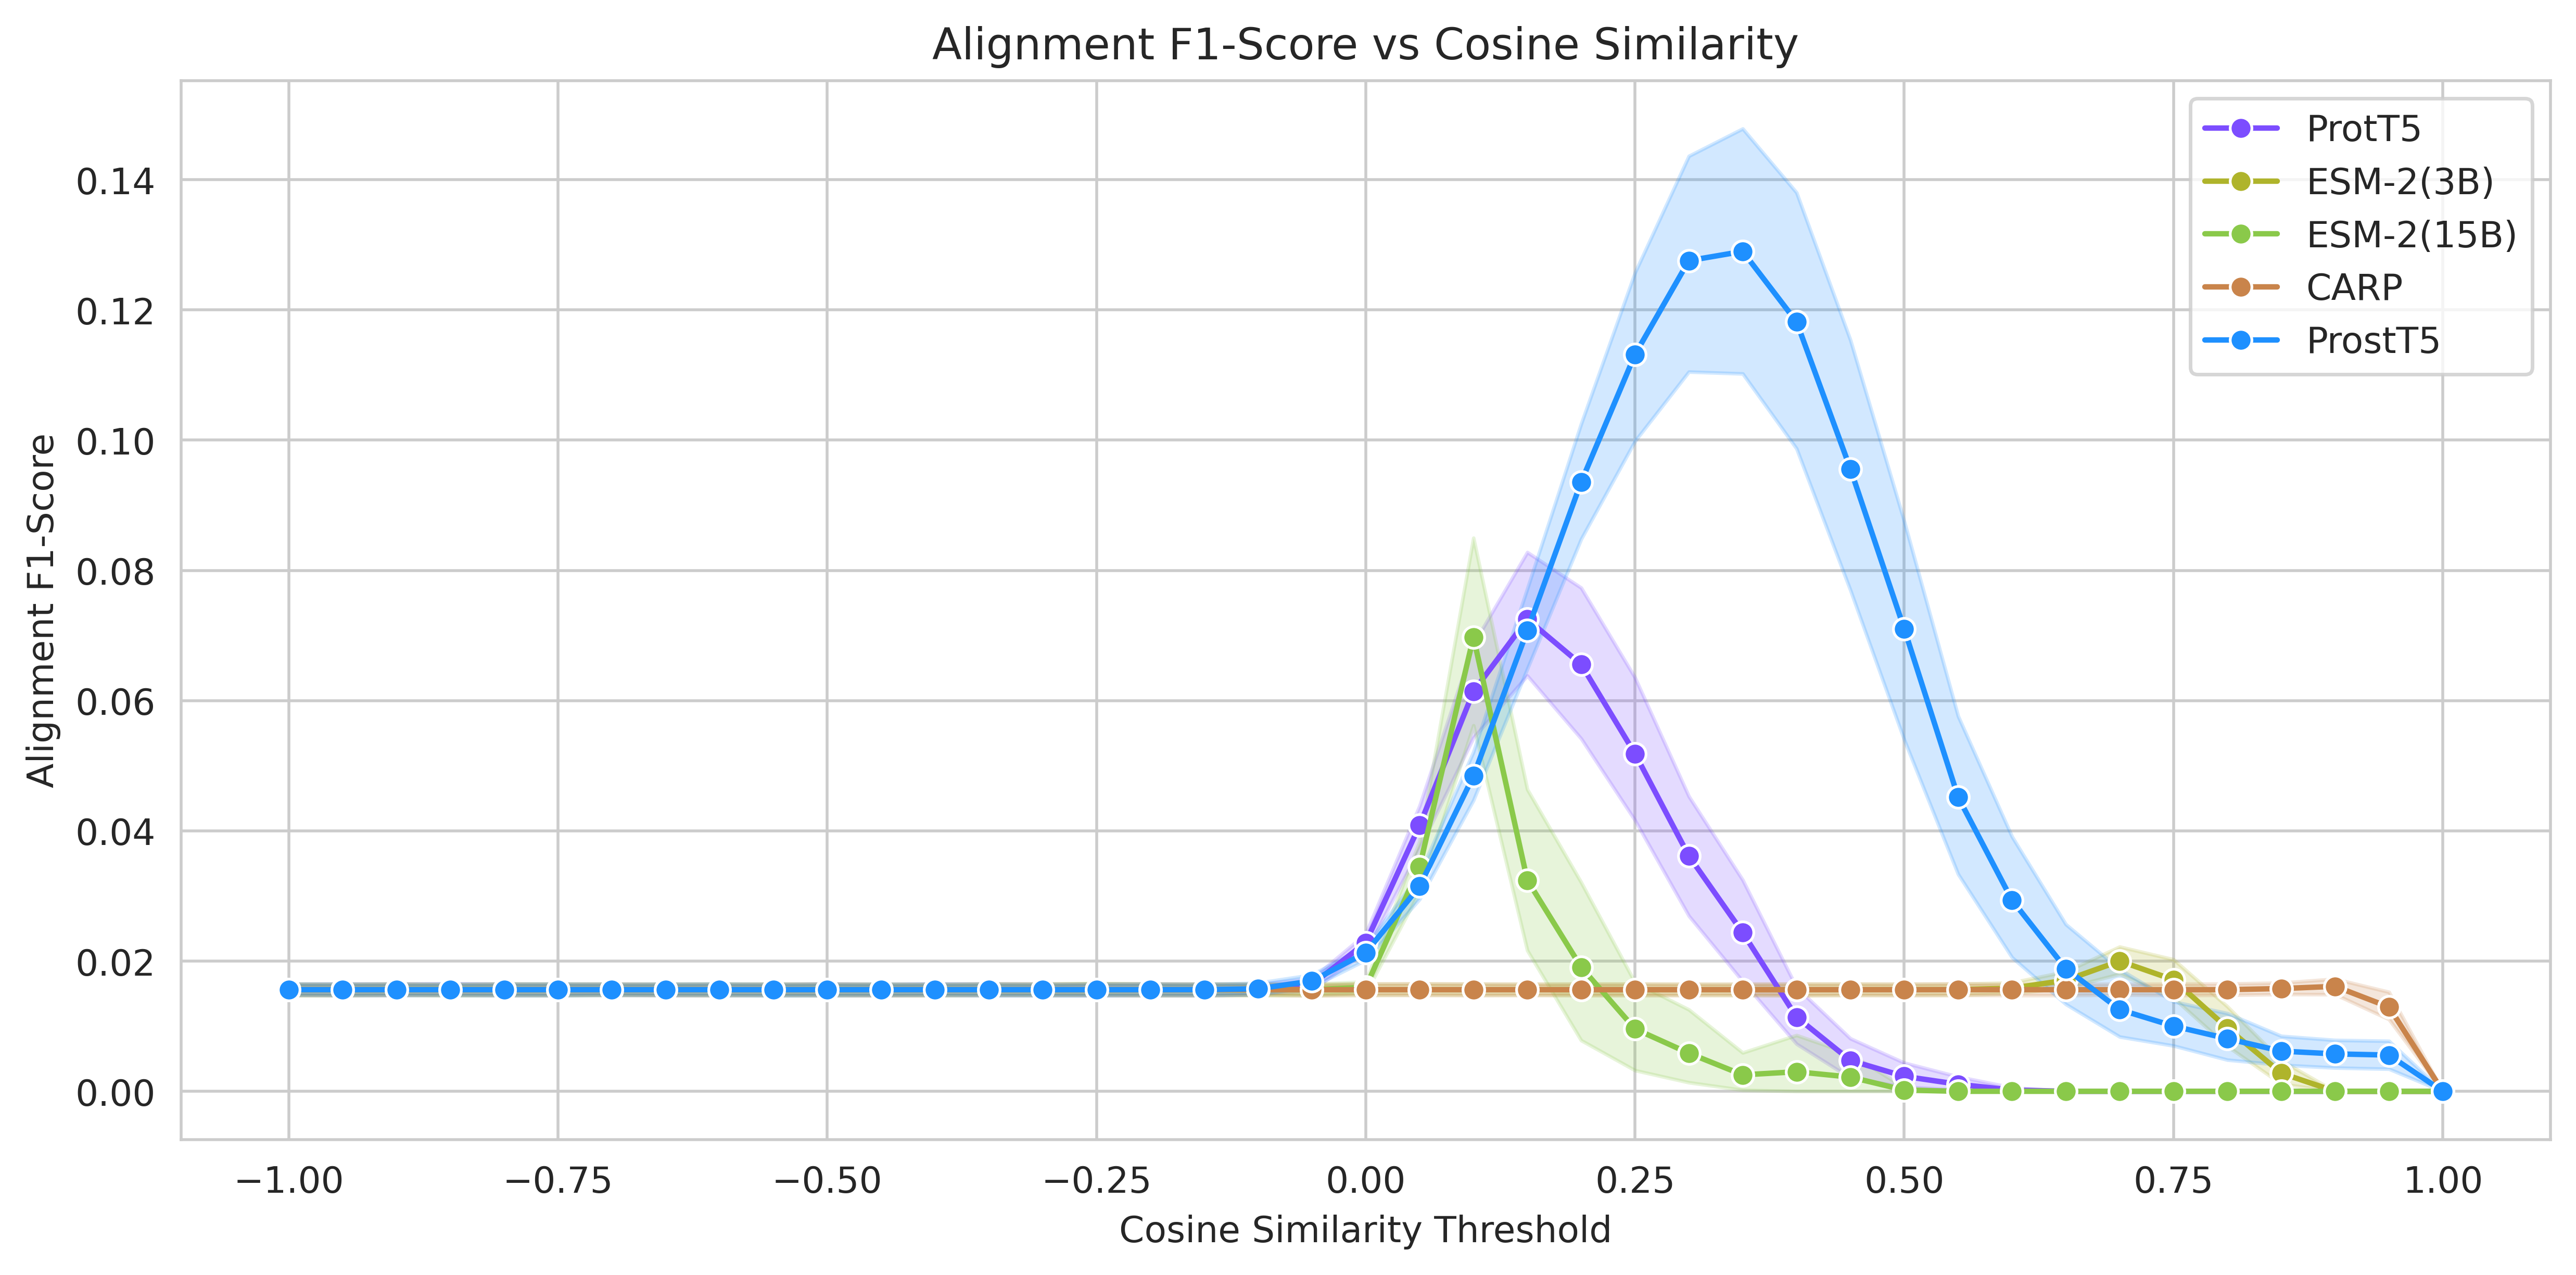

In [5]:
def plot_threshold_score_curve(results_df, score):
    plt.figure(figsize=(10, 5), dpi=500)
    sns.set_style("whitegrid")

    sns.lineplot(
        data=results_df,
        x='threshold',
        y=score,
        hue='method',
        marker='o',
        palette={'ProtT5': '#7C4DFF', 'ESM-2(3B)': '#AFB42B', 'ESM-2(15B)': '#8AC94A', 'CARP': '#C9844B', 'ProstT5': '#1E90FF'}
    )

    plt.xlabel("Cosine Similarity Threshold")
    plt.ylabel(f"Alignment {score}")
    plt.title(f"Alignment {score} vs Cosine Similarity")
    plt.legend(title=None)
    plt.tight_layout()
    plt.show()

plot_threshold_score_curve(results_df, 'Recall')
plot_threshold_score_curve(results_df, 'Precision')
plot_threshold_score_curve(results_df, 'F1-Score')